In [1]:
import os
from pathlib import Path
import re

import cv2
import matplotlib.pyplot as plt
from PIL import Image

import numpy as np
import math
import json
import pickle

# variant definition

In [2]:
image_dict = {
    # time info
    "capture_time": None,

    # image info
    "image_name": None,
    "image_rgb": None,
    
    "roll_deg": None,
    "pitch_deg": None,

    # image processing
    "image_processd_shrink": None,

    # segment
    "single_input": None,
    "single_label": None,
    "masks_single_input": None,
    "scores_single_input": None,
    "logits_single_input": None,

    "multi_input": None,
    "multi_label": None,
    "mask_multi_input": None,

    # features
    "mask_cleaned_multi_input": None,

    "outline_point": None,

    "longest_distance": None,
    "longest_pnt1": None,
    "longest_pnt2": None,
    "longest_orientation": None,

    "pole_left": None,
    "pole_right": None,
    "pole_top": None,
    "pole_bottom": None,
    "pole_orientation_lr": None,
    "pole_orientation_tb": None,

    "area": None,

    # estimated angles
    "estimated_roll_deg": None,
    "estimated_pitch_deg": None
}

# path

In [3]:
mask_folder = "/home/subblue-3/nextGen/data/attitude_estimation_in_lab_20250820/image_mask/mask/"
output_contour_folder = "/home/subblue-3/nextGen/data/attitude_estimation_in_lab_20250820/contour/"
os.makedirs(output_contour_folder, exist_ok=True)

# func

## fill_image_dict

In [4]:
# fill in image_dict
# -----------------------------------------------------------------------------------#
# If do not want to save dictionaries, directly comment the content of this function
# -----------------------------------------------------------------------------------#
def fill_image_dict(dict_, image_index, key_name, value):
    dict_[image_index][key_name] = value

## extract_angles_from_filename

In [5]:
# extract roll and pitch angles from the filename
def extract_angles_from_filename(filename):
    # match = re.search(r'roll([-+]?\d*\.\d+|\d+)_pitch([-+]?\d*\.\d+|\d+)\.jpg', filename)
    match = re.search(r'roll([-+]?\d*\.?\d+)_pitch([-+]?\d*\.?\d+)\.png', filename)
    if match:
        roll_angle = float(match.group(1))
        pitch_angle = float(match.group(2))
        return roll_angle, pitch_angle
    else:
        # If there is no match, return a tuple that sorts last
        return None, None

## display

### display_quick_one_image

**Library/Function**    **Format**      **Channel Order**

cv2.imread()                BGR         [Blue, Green, Red]

matplotlib.imshow()         RGB         [Red, Green, Blue]

PIL.Image.open()            RGB         [Red, Green, Blue]

Web browsers                RGB         [Red, Green, Blue]


In [6]:
def display_quick_one_image(image, 
                            title="",
                            title_size=12,
                            figsize=(8, 5),
                            cmap="",
                            show_axes=False,
                            x_axis="",
                            y_axis="",
                            show_grid=False,
                            save_path=None):
    
    if image is None:
        print(f"Error from display_quick_one_image: Could not load image from {image}")
        return
    
    plt.figure(figsize=figsize)
    
    if cmap == 'gray':
        plt.imshow(image, cmap='gray')
    else:
        # default image format is (BGR) is image = cv2.imread(image_path)
        # other libaries, eg. matplotlib, PIL/Pillow, all use RGB as default format
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        plt.imshow(image)
    
    plt.title(f"{title}", fontsize=title_size, fontweight='bold')
    
    if show_axes:
        plt.axis('on')
        if x_axis:
            plt.xlabel(x_axis, fontsize=10)
        if y_axis:
            plt.ylabel(y_axis, fontsize=10)
    else:
        plt.axis('off')
    
    if show_grid:
        plt.grid(True, alpha=0.5) #, color='gray')
    else:
        plt.grid(False)
    
    plt.tight_layout()
    plt.show()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')    
        plt.close()
        
        # • dpi = Dots Per Inch (resolution)"
        # • Higher DPI = Better quality, larger file size"
        # • Default matplotlib DPI is usually 100
        # • Common values:"
        #    dpi=72   → Screen resolution (low quality)")
        #    dpi=150  → Good for web")
        #    dpi=300  → Print quality (high quality)")
        #    dpi=600  → Professional printing")
    
        # "bbox_inches":
        # • Controls how much whitespace around the plot to include"
        #     bbox_inches=None     → Include all whitespace (default)"
        #     bbox_inches='tight'  → Minimize whitespace", removes extra padding, making image more compact
        #     bbox_inches='standard' → Standard matplotlib padding"



### display_one_mask

In [7]:
def display_one_mask(mask, ttl=""):
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    unique_values = np.unique(mask)
    
    plt.figure(figsize=(10, 8))
    plt.imshow(mask, cmap='viridis')
    plt.title(f'Mask Image\nUnique values: {unique_values}\nShape: {mask.shape}')
    plt.colorbar(label='Pixel Values')
    plt.axis('off')
    plt.show()
    
    print(f"Mask statistics:")
    print(f"  Shape: {mask.shape}")
    print(f"  Unique values: {unique_values}")
    print(f"  Value range: {mask.min()} - {mask.max()}")

### display_all_images_grid

In [8]:
def display_all_images_grid(image_folder, max_images=None, figsize_per_image=(5, 3),
                          cmap='gray', show_filenames=True, sort_files=True):
    """
    Display multiple images in a grid layout

    Args:
        image_folder: Path to folder containing images
        max_images: Maximum number of images to display (None for all)
        figsize_per_image: Size of each subplot, (width, hight) for each image
        cmap: Colormap for displaying images
        show_filenames: Whether to show filenames as titles
        sort_files: Whether to sort filenames
    """
    # Get all image files
    image_files = []
    valid_extensions = {'.png', '.jpg', '.jpeg', '.bmp', '.tiff', '.tif'}

    for file in os.listdir(image_folder):
        if Path(file).suffix.lower() in valid_extensions:
            image_files.append(file)

    if sort_files:
        image_files.sort()

    if max_images:
        image_files = image_files[:max_images]

    if not image_files:
        print("No image files found in the folder!")
        return

    # Calculate grid dimensions
    n_images = len(image_files)
    cols = math.ceil(math.sqrt(n_images))
    rows = math.ceil(n_images / cols)

    # Create figure
    fig_width = cols * figsize_per_image[0]
    fig_height = rows * figsize_per_image[1]
    fig, axes = plt.subplots(rows, cols, figsize=(fig_width, fig_height))

    # Handle single image case
    if n_images == 1:
        axes = [axes]
    elif rows == 1:
        axes = [axes] if cols == 1 else axes
    else:
        axes = axes.flatten()

    # Display each image
    for i, filename in enumerate(image_files):
        if i >= len(axes):
            break

        # Load and display image
        image_path = os.path.join(image_folder, filename)
        try:
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            if image is None:
                image = np.array(Image.open(image_path).convert('L'))

            axes[i].imshow(image, cmap=cmap)
            if show_filenames:
                axes[i].set_title(filename, fontsize=12, pad=2)
            axes[i].axis('off')

        except Exception as e:
            axes[i].text(0.5, 0.5, f'Error loading:\n{filename}\n{str(e)}',
                        ha='center', va='center', transform=axes[i].transAxes)
            axes[i].axis('off')


    # Hide unused subplots
    for i in range(len(image_files), len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.suptitle(f'All images in Folder ({len(image_files)} images)', y=0.98)
    plt.show()

    print(f"Displayed {len(image_files)} images")


## features

### calculate diameter
the longest line between two outline points

In [9]:
from scipy.spatial.distance import pdist, squareform

# Function to calculate the longest distance between points in a set of points
def calculate_longest_distance(outline_points):
    # Calculate pairwise distances
    distances = squareform(pdist(outline_points))

    # Get the indices of the two points with the maximum distance
    i, j = np.unravel_index(distances.argmax(), distances.shape)
    long_pnt1, long_pnt2 = outline_points[i], outline_points[j]

    # Euclidean longest distance
    longest_distance = np.sqrt((long_pnt1[0] - long_pnt2[0])**2 + (long_pnt1[1] - long_pnt2[1])**2)  # Euclidean distance

    return longest_distance, long_pnt1, long_pnt2

### calculate orientation of line

In [10]:
def calculate_orientation_degree_acrossX(long_pnt1, long_pnt2):
    # Calculate the orientation of longest distance line across X Y
    delta_y = long_pnt2[1] - long_pnt1[1]
    delta_x = long_pnt2[0] - long_pnt1[0]
    angle_acrossX = math.atan2(delta_y, delta_x) * 180 / math.pi

    # Convert the angle to orientation in the range of 0 to 180 degrees
    longest_orientation_acrossX = angle_acrossX if angle_acrossX >= 0 else angle_acrossX + 180

    longest_orientation_acrossX = round(longest_orientation_acrossX, 2)

    return longest_orientation_acrossX

# load ground truth masks

In [11]:
all_gt_mask = os.listdir(mask_folder)
num_mask = len(all_gt_mask)
print(f"len of all_gt_mask: {num_mask}")

all_gt_mask

len of all_gt_mask: 25


['roll18.84_pitch13.81.png',
 'roll-22.92_pitch17.6.png',
 'roll-16.01_pitch-15.29.png',
 'roll-3.3_pitch21.7.png',
 'roll19.75_pitch-19.9.png',
 'roll-13.13_pitch19.76.png',
 'roll-7.24_pitch-12.79.png',
 'roll-9.44_pitch-2.0.png',
 'roll-21.27_pitch6.51.png',
 'roll-1.65_pitch10.85.png',
 'roll11.5_pitch-20.48.png',
 'roll8.15_pitch12.5.png',
 'roll0_pitch0.png',
 'roll10.62_pitch-9.46.png',
 'roll-11.4_pitch8.85.png',
 'roll1.65_pitch-10.85.png',
 'roll17.44_pitch24.95.png',
 'roll6.56_pitch23.43.png',
 'roll9.51_pitch1.54.png',
 'roll-4.81_pitch-23.53.png',
 'roll-12.76_pitch-25.97.png',
 'roll19.67_pitch2.61.png',
 'roll3.3_pitch-21.7.png',
 'roll19.97_pitch-8.63.png',
 'roll-18.78_pitch-4.46.png']

In [12]:
test_file_name = all_gt_mask[0]
test_mask_path = os.path.join(mask_folder, test_file_name)
test_img = cv2.imread(test_mask_path, cv2.IMREAD_GRAYSCALE)
test_img.shape

(1080, 1920)

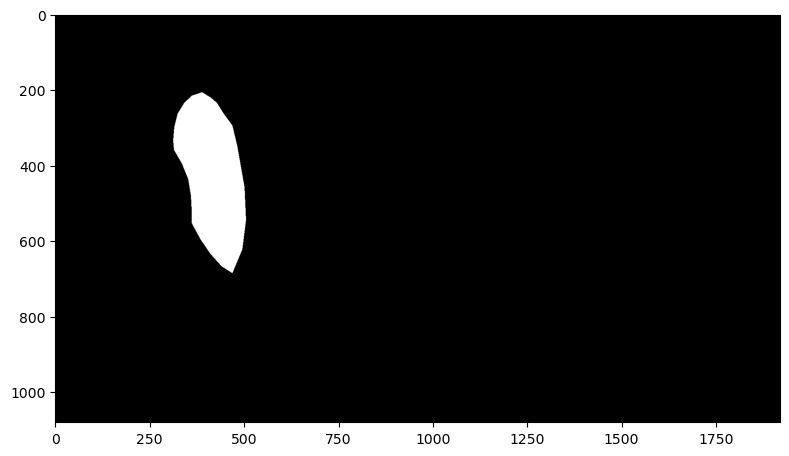

In [13]:
display_quick_one_image(test_img, cmap='gray', show_axes=True)

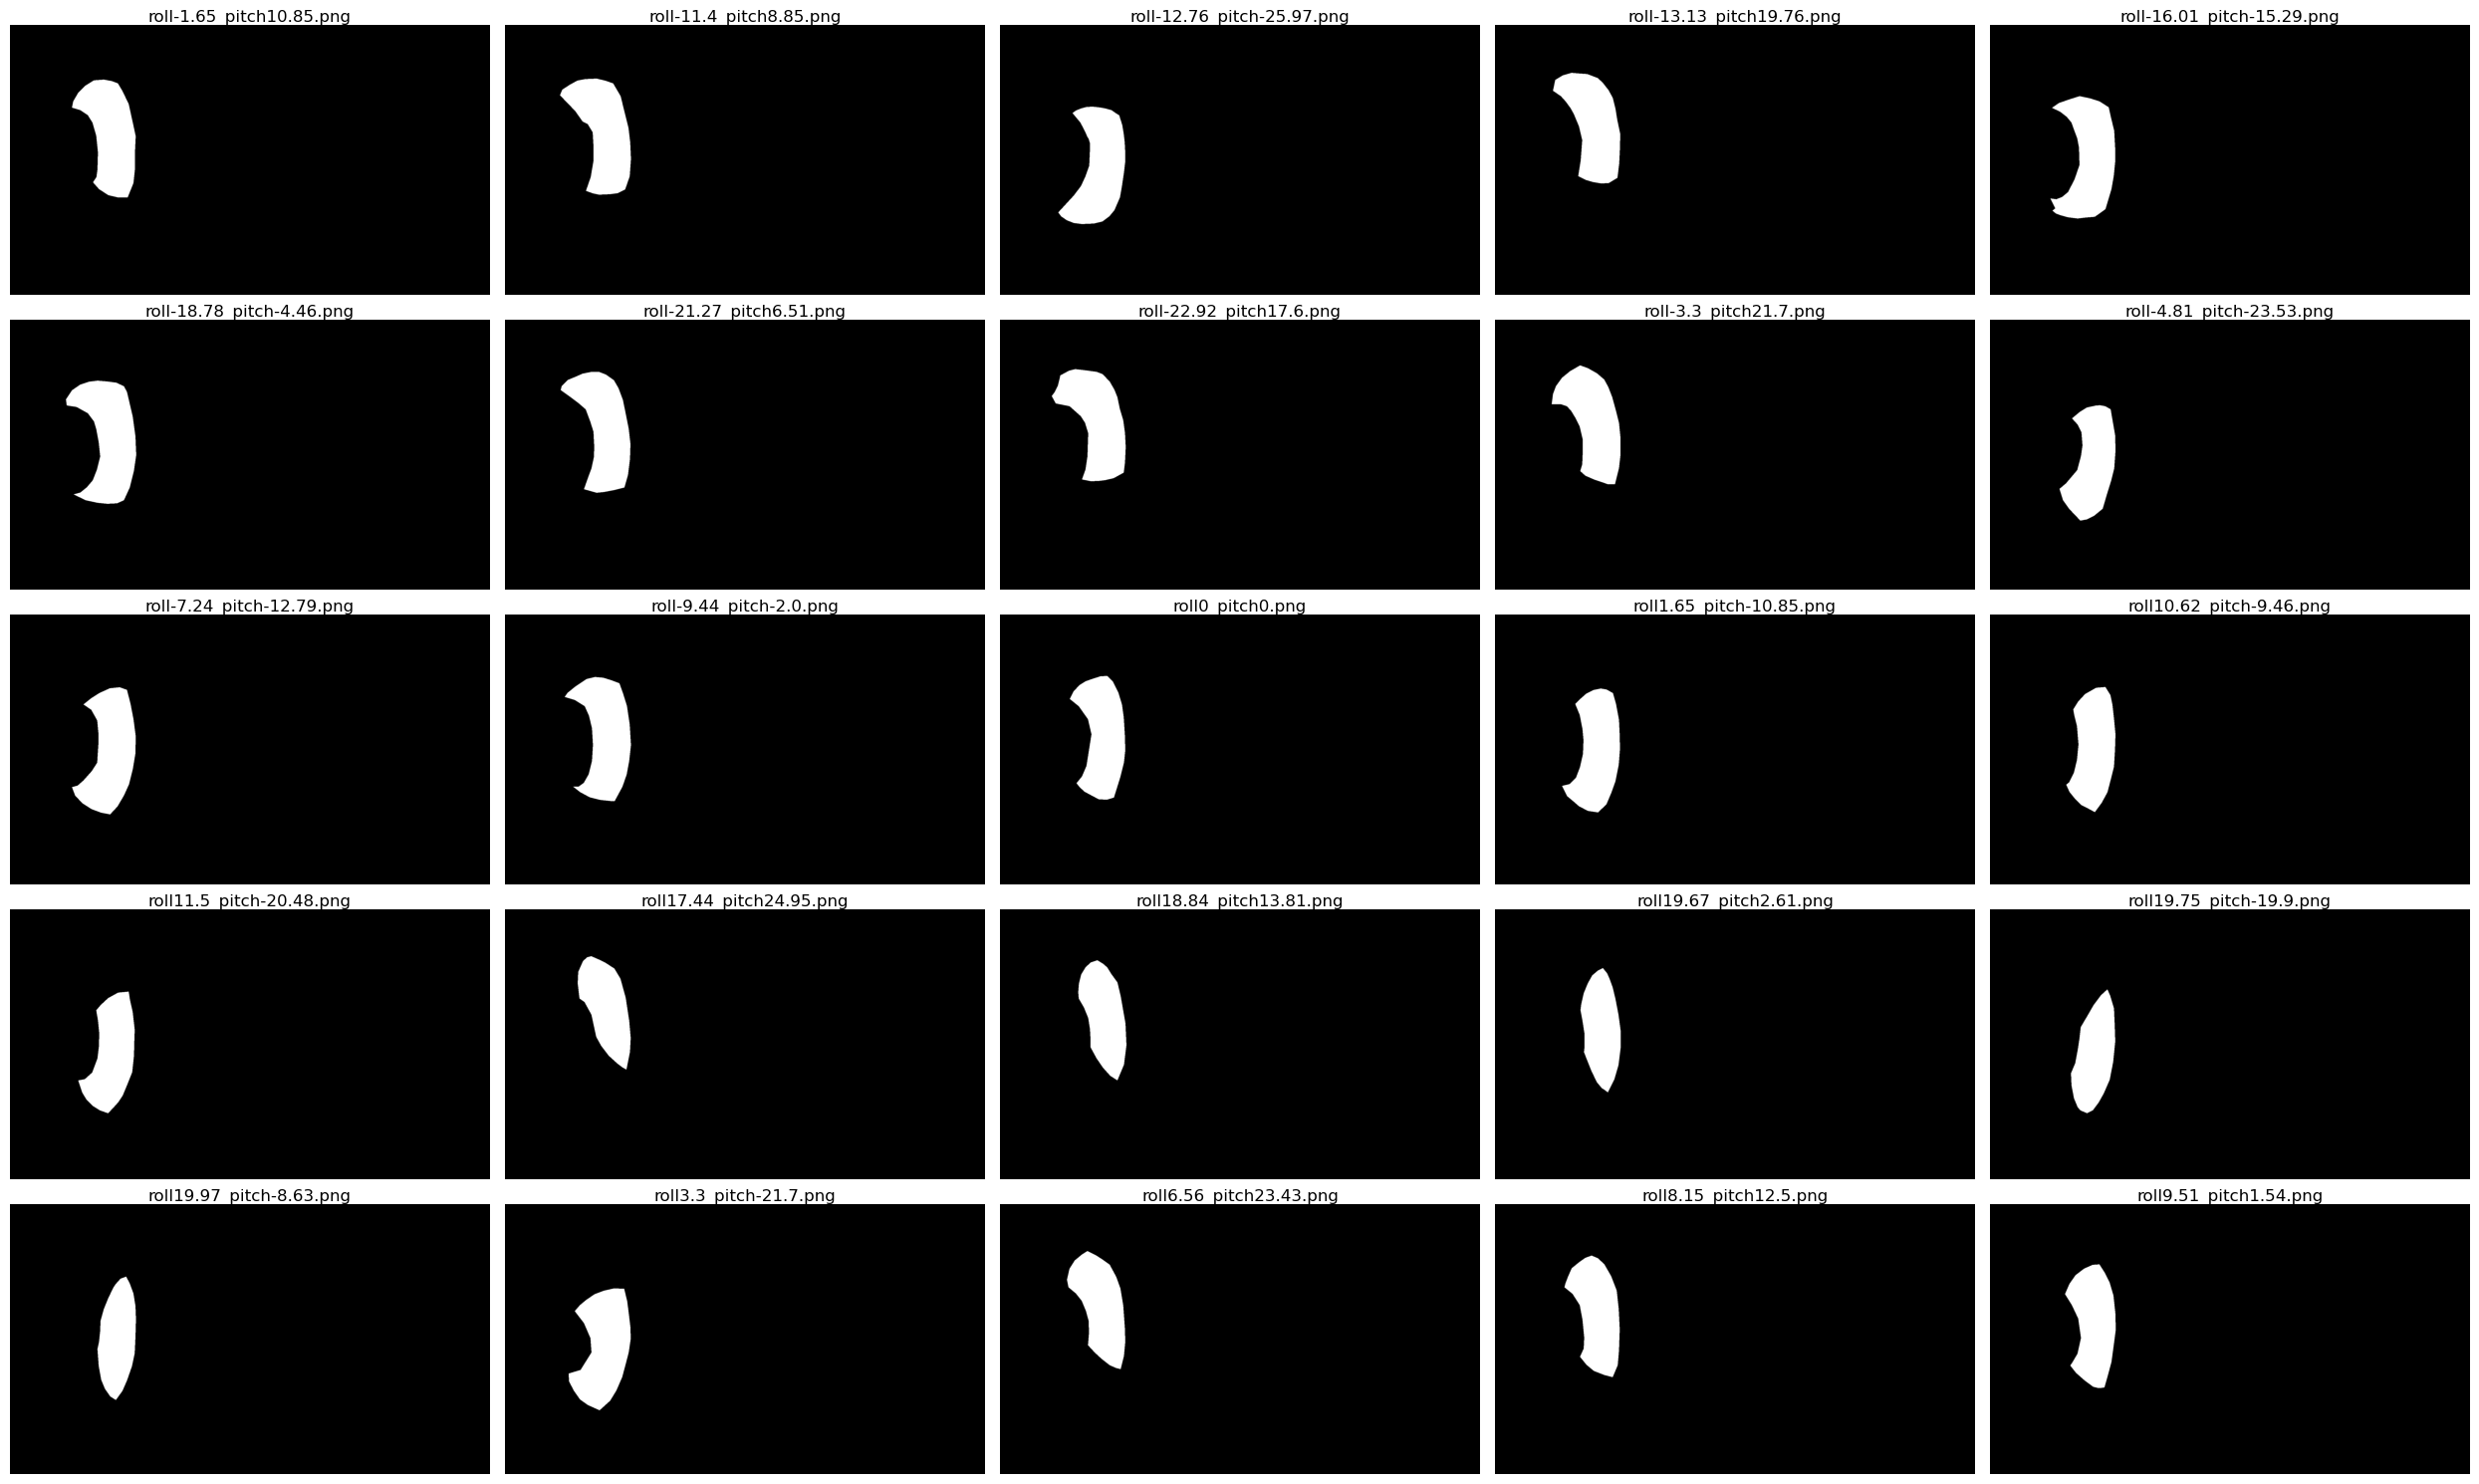

Displayed 25 images


In [40]:
display_all_images_grid(mask_folder, cmap='gray', figsize_per_image = (5, 3))  # image shape = (1080, 1920, 3), so 5 * 1080 / 1920 = 2.8 -> 3

# calculate mask area

In [14]:
# Store areas for all masks
all_mask_areas = {}  # Store areas for each mask
class_areas_all_masks = {}  # Store areas by class across all masks
total_object_areas = {}  # Store total object area per mask

print("Calculating areas for all masks...")
print("=" * 60)

for mask_name in all_gt_mask:
    if not mask_name.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff', '.tif')):
        continue
        
    print(f"Processing: {mask_name}")
    
    try:
        mask = cv2.imread(os.path.join(mask_folder, mask_name), cv2.IMREAD_GRAYSCALE)
        if mask is None:
            print(f"  Error: Could not load {mask_name}")
            continue
            
        # Get unique values (classes)
        unique_values = np.unique(mask)
        
        # Calculate areas
        total_pixels = mask.shape[0] * mask.shape[1]
        background_pixels = np.sum(mask == 0)
        total_object_area = total_pixels - background_pixels
        
        # Store total object area for this mask
        total_object_areas[mask_name] = total_object_area
        
        # Detailed breakdown for this specific mask
        area_by_class = {}  # Reset for each mask
        
        for value in unique_values:
            class_area = np.sum(mask == value)
            if value == 0:
                area_by_class['background'] = class_area
                print(f"  Background area: {class_area}")
            else:
                area_by_class[f'class_{value}'] = class_area
                print(f"  Class {value} area: {class_area}")
                
                # Track this class across all masks
                class_key = f'class_{value}'
                if class_key not in class_areas_all_masks:
                    class_areas_all_masks[class_key] = []
                class_areas_all_masks[class_key].append({
                    'mask_name': mask_name,
                    'area': class_area
                })
        
        # Store areas for this mask
        all_mask_areas[mask_name] = {
            'total_object_area': total_object_area,
            'total_pixels': total_pixels,
            'background_area': background_pixels,
            'coverage_percent': (total_object_area / total_pixels) * 100,
            'area_by_class': area_by_class,
            'unique_classes': [v for v in unique_values if v != 0]
        }
        
        print(f"  Total obj"
              f"ect area: {total_object_area} ({(total_object_area/total_pixels)*100:.2f}%)")
        print(f"  Classes found: {[v for v in unique_values if v != 0]}")
        print()
        
    except Exception as e:
        print(f"  Error processing {mask_name}: {e}")
        continue

print("=" * 60)
print("FINDING MINIMUM AREAS")
print("=" * 60)

# Find minimum area for each class across all masks
print(f"MINIMUM AREAS BY CLASS:")
class_minimums = {}

for class_name, class_data in class_areas_all_masks.items():
    if class_data:  # If we have data for this class
        min_entry = min(class_data, key=lambda x: x['area'])
        class_minimums[class_name] = min_entry
        
        print(f"  {class_name}:")
        print(f"    Minimum area: {min_entry['area']:,} pixels")
        print(f"    Found in mask: {min_entry['mask_name']}")

Calculating areas for all masks...
Processing: roll18.84_pitch13.81.png
  Background area: 2014014
  Class 255 area: 59586
  Total object area: 59586 (2.87%)
  Classes found: [255]

Processing: roll-22.92_pitch17.6.png
  Background area: 1997023
  Class 255 area: 76577
  Total object area: 76577 (3.69%)
  Classes found: [255]

Processing: roll-16.01_pitch-15.29.png
  Background area: 1994451
  Class 255 area: 79149
  Total object area: 79149 (3.82%)
  Classes found: [255]

Processing: roll-3.3_pitch21.7.png
  Background area: 1998198
  Class 255 area: 75402
  Total object area: 75402 (3.64%)
  Classes found: [255]

Processing: roll19.75_pitch-19.9.png
  Background area: 2016202
  Class 255 area: 57398
  Total object area: 57398 (2.77%)
  Classes found: [255]

Processing: roll-13.13_pitch19.76.png
  Background area: 2001598
  Class 255 area: 72002
  Total object area: 72002 (3.47%)
  Classes found: [255]

Processing: roll-7.24_pitch-12.79.png
  Background area: 1996333
  Class 255 area:

# extract contour

## for test single mask

In [15]:
all_gt_mask[0]

'roll18.84_pitch13.81.png'

In [16]:
roll_true, pitch_true = extract_angles_from_filename(all_gt_mask[0])
roll_true, pitch_true

(18.84, 13.81)

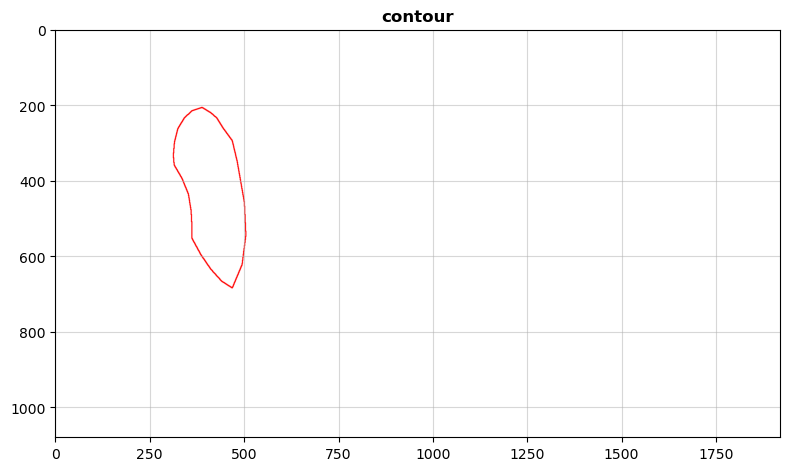

In [17]:
mask = cv2.imread(test_mask_path, cv2.IMREAD_GRAYSCALE)
min_area=25000

if mask is None:
    raise ValueError(f"Could not load mask: {test_mask_path}")

"""
# For multi-class masks, process each class separately
unique_values = np.unique(mask)
all_contours = []
all_labels = []

for value in unique_values: 
    class_area = np.sum(mask == value)
"""

# for only one class (mask value = 255, ground = 0)
value = 255 
        
# Create binary mask for this class
binary_mask = (mask == value).astype(np.uint8) * 255

contours, hierarchy = cv2.findContours(
    binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE  # NONE = keep all points
)

if contours:    # If there are no contours (all black image), avoid proceeding to prevent errors
    # Calculate areas
    areas = [cv2.contourArea(cnt) for cnt in contours]
    
    # Get the index of the largest contour
    largest_contour_index = np.argmax(areas)
    largest_area = areas[largest_contour_index]
    
    if largest_area >= min_area:
        largest_contour = contours[largest_contour_index]
        
        # all_contours.append(largest_contour)
        # all_labels.append(int(value))
        
        # Prepare a white background
        contour_img = np.ones((mask.shape[0], mask.shape[1], 3), dtype=np.uint8) * 255
        cv2.drawContours(contour_img, contours, -1, (0, 0, 255), 2)  # Red in BGR, thickness=2

        # Save using matplotlib (with axis and white background)
        display_quick_one_image(image=contour_img, title="contour", show_axes=True, show_grid=True)


In [18]:
largest_contour.shape

(996, 1, 2)

In [19]:
contour_points = largest_contour.reshape(-1, 2)
contour_points.shape

(996, 2)

Saving /home/subblue-3/nextGen/data/attitude_estimation_in_lab_20250820/contour/test_focus_on_contour/roll18.84_pitch13.81.png


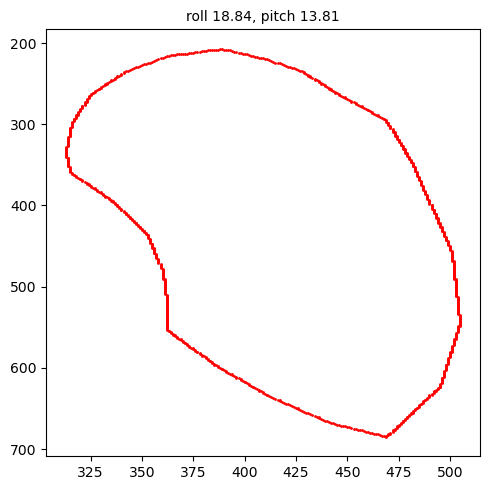

In [20]:
# @title show examples in horizontal row
num_example_images = 1  # Since you have one contour

fig, axs = plt.subplots(1, num_example_images, figsize=(5*num_example_images, 5))

# Convert contour from OpenCV format (N, 1, 2) to simple format (N, 2)
contour_points = largest_contour.reshape(-1, 2)

# If there's only one image, axs will be a 1-D array  
ax = axs if num_example_images == 1 else axs[0]

ax.plot(contour_points[:, 0], contour_points[:, 1], 'r.', markersize=2)  # Display the outline points in red
ax.set_title(f"roll {roll_true}, pitch {pitch_true}", fontsize=10)
ax.axis('on')
ax.invert_yaxis()  # Inverting the y-axis to have the origin at the top-left

# # Focus on the contour area:
# x_min, x_max = contour_points[:, 0].min(), contour_points[:, 0].max()
# y_min, y_max = contour_points[:, 1].min(), contour_points[:, 1].max()
# padding = 50  # Add some padding around the contour
# ax.set_xlim(x_min - padding, x_max + padding)
# ax.set_ylim(y_max + padding, y_min - padding)  # Inverted for image coordinates

save_path = os.path.join(output_contour_folder, "test_focus_on_contour/", test_file_name)
print(f"Saving {save_path}")
plt.savefig(save_path, dpi=300, bbox_inches='tight')   

plt.tight_layout()
plt.show()
plt.close()

## for all ground truth masks

In [21]:
min_area=25000

for mask_name in all_gt_mask:
    
    mask_path = os.path.join(mask_folder, mask_name)

    roll_true, pitch_true = extract_angles_from_filename(mask_path)
    
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    if mask is None:
        raise ValueError(f"Could not load mask: {mask_path}")
    

    # Create binary mask for this class
    value = 255
    binary_mask = (mask == value).astype(np.uint8) * 255
    
    contours, hierarchy = cv2.findContours(
        binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE  # NONE = keep all points
    )

    if contours:    # If there are no contours (all black image), avoid proceeding to prevent errors
        # Calculate areas
        areas = [cv2.contourArea(cnt) for cnt in contours]
        
        # Get the index of the largest contour
        largest_contour_index = np.argmax(areas)
        largest_area = areas[largest_contour_index]
        
        if largest_area >= min_area:
            largest_contour = contours[largest_contour_index]

            # Prepare a white background
            contour_img = np.ones((mask.shape[0], mask.shape[1], 3), dtype=np.uint8) * 255
            cv2.drawContours(contour_img, contours, -1, (0, 0, 255), 2)  # Red in BGR, thickness=2
    
    contour_points = largest_contour.reshape(-1, 2)
    
    # display and save focus on contour
    num_example_images = 1  # Since you have one contour

    fig, axs = plt.subplots(1, num_example_images, figsize=(5*num_example_images, 5))
    
    ax = axs if num_example_images == 1 else axs[0]
    ax.plot(contour_points[:, 0], contour_points[:, 1], 'r.', markersize=2)  # Display the outline points in red
    ax.set_title(f"roll {roll_true}, pitch {pitch_true}", fontsize=10)
    ax.axis('on')
    ax.invert_yaxis()  # Inverting the y-axis to have the origin at the top-left
    
    # # Focus on the contour area:
    # x_min, x_max = contour_points[:, 0].min(), contour_points[:, 0].max()
    # y_min, y_max = contour_points[:, 1].min(), contour_points[:, 1].max()
    # padding = 50  # Add some padding around the contour
    # ax.set_xlim(x_min - padding, x_max + padding)
    # ax.set_ylim(y_max + padding, y_min - padding)  # Inverted for image coordinates

    focus_on_contour_path = os.path.join(output_contour_folder, "focus_on_contour/", mask_name)
    plt.savefig(focus_on_contour_path, dpi=300, bbox_inches='tight')   
    
    plt.tight_layout()
    # plt.show()
    plt.close()

# extract geometric features

## for test single mask

In [22]:
roll_true, pitch_true = extract_angles_from_filename(test_file_name)
roll_true, pitch_true

(18.84, 13.81)

In [23]:
unique_values = np.unique(mask)
unique_values

array([  0, 255], dtype=uint8)

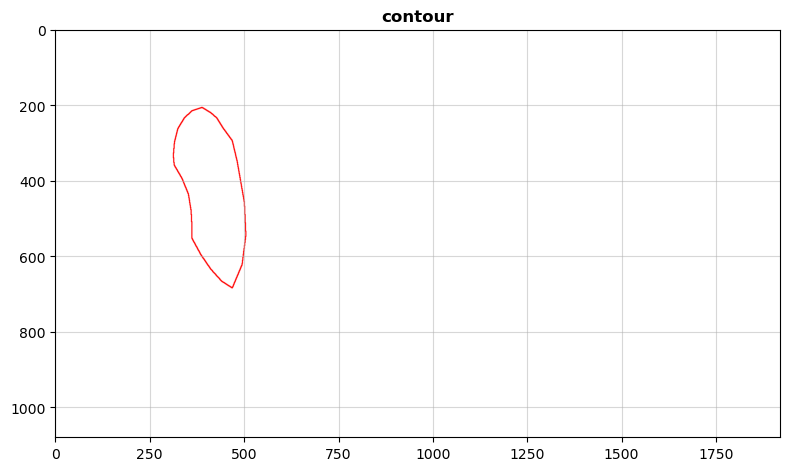

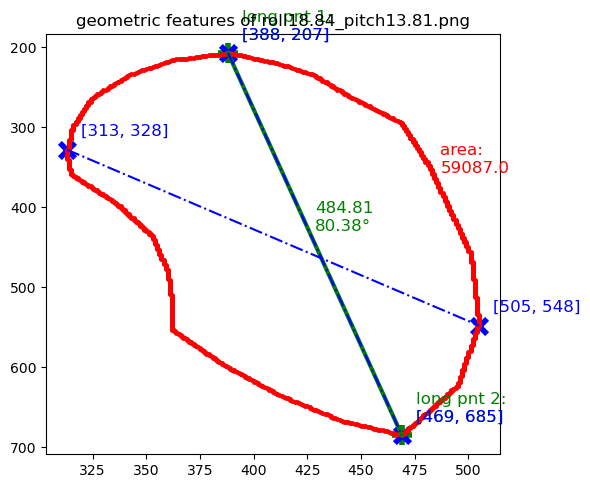

In [28]:
mask = cv2.imread(test_mask_path, cv2.IMREAD_GRAYSCALE)
min_area = 25000

if mask is None:
    raise ValueError(f"Could not load mask: {test_mask_path}")

"""
# For multi-class masks, process each class separately
unique_values = np.unique(mask)
all_contours = []
all_labels = []

for value in unique_values: 
    class_area = np.sum(mask == value)
"""

# for only one class (mask value = 255, ground = 0)
value = 255

# Create binary mask for this class
binary_mask = (mask == value).astype(np.uint8) * 255

contours, hierarchy = cv2.findContours(
    binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE  # NONE = keep all points
)

if contours:  # If there are no contours (all black image), avoid proceeding to prevent errors
    # Calculate areas
    areas = [cv2.contourArea(cnt) for cnt in contours]

    # Get the index of the largest contour
    largest_contour_index = np.argmax(areas)
    largest_area = areas[largest_contour_index]

    if largest_area >= min_area:
        largest_contour = contours[largest_contour_index]

        # Prepare a white background
        contour_img = np.ones((mask.shape[0], mask.shape[1], 3), dtype=np.uint8) * 255
        cv2.drawContours(contour_img, contours, -1, (0, 0, 255), 2)  # Red in BGR, thickness=2

        # Save using matplotlib (with axis and white background)
        display_quick_one_image(image=contour_img, title="contour", show_axes=True, show_grid=True)

    contour_points = largest_contour.reshape(-1, 2)
    
    # -------------------- longest distance -------------------- #
    longest_distance, long_pnt1, long_pnt2 = calculate_longest_distance(contour_points)
    longest_orientation = calculate_orientation_degree_acrossX(long_pnt1, long_pnt2)

    # -------------------- poles -------------------- #
    pole_left = contour_points[np.argmin(contour_points[:, 0])]
    pole_right = contour_points[np.argmax(contour_points[:, 0])]
    pole_top = contour_points[np.argmin(contour_points[:, 1])]
    pole_bottom = contour_points[np.argmax(contour_points[:, 1])]

    pole_orientation_lr = calculate_orientation_degree_acrossX(pole_left, pole_right)
    pole_orientation_tb = calculate_orientation_degree_acrossX(pole_top, pole_bottom)

    # -------------------- area -------------------- #
    max_area = largest_area
    
    
    # fig, axs = plt.subplots(1, 1, figsize=(30, 6))
    plt.figure(figsize=(6, 5))

    # ax = axs[0]
    plt.plot(contour_points[:, 0], contour_points[:, 1], 'r.', markersize=5)  # Displaying only the outline points

    # Plotting a green line connecting the two points with the maximum distance
    plt.plot(*zip(long_pnt1, long_pnt2), color='green', linestyle='-', linewidth=3)

    points_long = {'long pnt 1': long_pnt1, 'long pnt 2': long_pnt2}
    for label, point in points_long.items():
      plt.scatter(*point, color='green', marker='+', s=200, linewidth=4)
      plt.annotate(f'{label}:\n[{point[0]}, {point[1]}]', (point[0], point[1]), textcoords="offset points", xytext=(10,10), ha='left', fontsize=12, color='green')

    # Plotting the most left, right, top, and bottom points
    for label, point in [('pole_left', pole_left), ('pole_right', pole_right), ('pole_top', pole_top), ('pole_bottom', pole_bottom)]:
        plt.scatter(*point, color='blue', marker='x', s=120, linewidth=4)
        plt.annotate(f'[{point[0]}, {point[1]}]', (point[0], point[1]), textcoords="offset points", xytext=(10,10), ha='left', fontsize=12, color='blue')

    plt.plot(*zip(pole_left, pole_right), color='blue', linestyle='-.', linewidth=1.5)
    plt.plot(*zip(pole_top, pole_bottom), color='blue', linestyle='-.', linewidth=1.5)

    # Annotate the distance value and orientation on the plot
    midpoint = ((long_pnt1[0] + long_pnt2[0]) / 2, (long_pnt1[1] + long_pnt2[1]) / 2)
    # plt.annotate(f'longest distance:\n{longest_distance:.2f}\norientation:\n{longest_orientation:.2f}°', midpoint, textcoords="offset points", xytext=(0,10), ha='left', fontsize=12, color='green')
    plt.annotate(f'{longest_distance:.2f}\n{longest_orientation:.2f}°',
                  xy=midpoint,
                  textcoords="offset points",
                  xytext=(0,10),
                  ha='left',
                  fontsize=12,
                  color='green')

    # plot area
    area_ann_point = (pole_right[0] - (pole_right[0]-pole_left[0])/4 +30,
                      pole_top[1] + (pole_bottom[1] - pole_top[1])/4 +30)
    plt.annotate(f'area:\n{max_area}', area_ann_point, textcoords="offset points", xytext=(0, 0), ha='left', fontsize=12, color='red')

    plt.title(f"geometric features of {test_file_name}")
    plt.axis('on')

    plt.gca().invert_yaxis()  # Inverting the y-axis to have the origin at the top-left


    plt.tight_layout()
    plt.show()


Saving /home/subblue-3/nextGen/data/attitude_estimation_in_lab_20250820/contour/test_focus_on_contour/roll18.84_pitch13.81.png


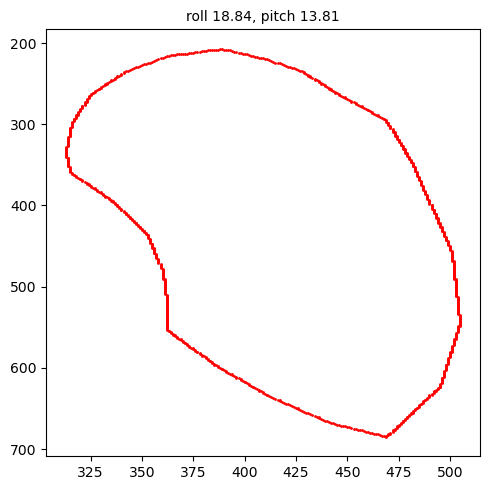

In [25]:
# @title show examples in horizontal row
num_example_images = 1  # Since you have one contour

fig, axs = plt.subplots(1, num_example_images, figsize=(5 * num_example_images, 5))

# Convert contour from OpenCV format (N, 1, 2) to simple format (N, 2)
contour_points = largest_contour.reshape(-1, 2)

# If there's only one image, axs will be a 1-D array  
ax = axs if num_example_images == 1 else axs[0]

ax.plot(contour_points[:, 0], contour_points[:, 1], 'r.', markersize=2)  # Display the outline points in red
ax.set_title(f"roll {roll_true}, pitch {pitch_true}", fontsize=10)
ax.axis('on')
ax.invert_yaxis()  # Inverting the y-axis to have the origin at the top-left

# # Focus on the contour area:
# x_min, x_max = contour_points[:, 0].min(), contour_points[:, 0].max()
# y_min, y_max = contour_points[:, 1].min(), contour_points[:, 1].max()
# padding = 50  # Add some padding around the contour
# ax.set_xlim(x_min - padding, x_max + padding)
# ax.set_ylim(y_max + padding, y_min - padding)  # Inverted for image coordinates

save_path = os.path.join(output_contour_folder, "test_focus_on_contour/", test_file_name)
print(f"Saving {save_path}")
plt.savefig(save_path, dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()
plt.close()

In [78]:
def extract_contours_from_mask(mask_path, min_area=25000, keep_all_points=True):
    """
    Extract contours from a single mask
    
    Args:
        mask_path: Path to mask image
        min_area: Minimum contour area to keep
        keep_all_points: If True, keeps all original contour points (no approximation)
    
    Returns:
        contours: List of contours
        hierarchy: Contour hierarchy
        mask_shape: Original mask dimensions
    """
    # Load mask
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    if mask is None:
        raise ValueError(f"Could not load mask: {mask_path}")
    
    # For multi-class masks, process each class separately
    unique_values = np.unique(mask)
    all_contours = []
    all_labels = []
    
    for value in unique_values:
        if value == 0:  # Skip background
            continue
            
        # Create binary mask for this class
        binary_mask = (mask == value).astype(np.uint8) * 255
        
        # Find contours with maximum detail preservation
        if keep_all_points:
            contours, hierarchy = cv2.findContours(
                binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE  # NONE = keep all points
            )
        else:
            contours, hierarchy = cv2.findContours(
                binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
            )
        
        if contours:    # If there are no contours (all black image), avoid proceeding to prevent errors
            # Calculate areas
            areas = [cv2.contourArea(cnt) for cnt in contours]
            
            # Get the index of the largest contour
            largest_contour_index = np.argmax(areas)
            largest_area = areas[largest_contour_index]
            
            if largest_area >= min_area:
                largest_contour = contours[largest_contour_index]
                
                all_contours.append(largest_contour)
                all_labels.append(int(value))
                
                # Prepare a white background
                contour_img = np.ones((mask.shape[0], mask.shape[1], 3), dtype=np.uint8) * 255
                cv2.drawContours(contour_img, contours, -1, (0, 0, 255), 1)  # Red in BGR, thickness=1
        
                # Save using matplotlib (with axis and white background)
                plt.figure(figsize=(6, 6))
                plt.imshow(cv2.cvtColor(contour_img, cv2.COLOR_BGR2RGB))
                plt.title(f"Contours - {mask_path}", fontsize=10)
                plt.axis('on')
                plt.show()
        
                # save_path = os.path.join(output_dir, filename)
                # plt.savefig(save_path, bbox_inches='tight')
                plt.close()

    
    return all_contours, all_labels, mask.shape

In [74]:
def save_contours_as_image(contours, labels, mask_shape, output_path, 
                          line_thickness=2, show_labels=False):
    """Save contours as image"""
    # Create blank image
    contour_image = np.zeros((mask_shape[0], mask_shape[1], 3), dtype=np.uint8)
    
    # Colors for different classes
    colors = [(0, 0, 255), (0, 255, 0), (255, 0, 0), (255, 255, 0), 
              (255, 0, 255), (0, 255, 255), (128, 128, 128), (255, 128, 0)]
    
    for i, (contour, label) in enumerate(zip(contours, labels)):
        color = (0, 0, 255)  #colors[label % len(colors)]
        
        # Draw contour
        cv2.drawContours(contour_image, [contour], -1, color, line_thickness)
        
        # Add label text
        if show_labels and len(contour) > 0:
            M = cv2.moments(contour)
            if M["m00"] != 0:
                cx = int(M["m10"] / M["m00"])
                cy = int(M["m01"] / M["m00"])
                cv2.putText(contour_image, str(label), (cx-10, cy), 
                           cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)
    
    # Save image
    cv2.imwrite(output_path, contour_image)
    return contour_image

In [75]:
def save_contours_as_coordinates(contours, labels, output_path, format='json'):
    """Save contour coordinates in various formats"""
    contour_data = []
    
    for contour, label in zip(contours, labels):
        # Convert contour to list of points
        points = contour.reshape(-1, 2).tolist()
        
        # Calculate additional properties
        area = cv2.contourArea(contour)
        perimeter = cv2.arcLength(contour, True)
        
        # Bounding box
        x, y, w, h = cv2.boundingRect(contour)
        
        contour_info = {
            'label': label,
            'points': points,
            'area': float(area),
            'perimeter': float(perimeter),
            'bounding_box': {'x': int(x), 'y': int(y), 'width': int(w), 'height': int(h)},
            'num_points': len(points)
        }
        contour_data.append(contour_info)
    
    # Save in requested format
    if format.lower() == 'json':
        with open(output_path, 'w') as f:
            json.dump(contour_data, f, indent=2)
    elif format.lower() == 'pickle':
        with open(output_path, 'wb') as f:
            pickle.dump(contour_data, f)
    elif format.lower() == 'txt':
        with open(output_path, 'w') as f:
            for i, data in enumerate(contour_data):
                f.write(f"Contour {i+1} (Label {data['label']}):\n")
                f.write(f"Area: {data['area']:.2f}\n")
                f.write(f"Perimeter: {data['perimeter']:.2f}\n")
                f.write("Points:\n")
                for point in data['points']:
                    f.write(f"  {point[0]}, {point[1]}\n")
                f.write("\n")
    
    return contour_data

In [80]:

def display_individual_contour_results(mask_path, all_contours, all_labels, mask_shape, 
                                     figsize=(15, 5), save_plot=False, output_folder=None):
    """
    Display contour results for individual images in a 3-panel format
    
    Args:
        mask_path: Path to the original mask file
        all_contours: List of extracted contours
        all_labels: List of contour labels
        mask_shape: Shape of the original mask
        figsize: Figure size (width, height)
        save_plot: Whether to save the plot
        output_folder: Folder to save plots (if save_plot=True)
    """
    
    # Load original mask
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    if mask is None:
        raise ValueError(f"Could not load mask: {mask_path}")
    
    # Get filename for title
    filename = Path(mask_path).name
    
    # Colors for different contours
    colors = ['red', 'green', 'blue', 'yellow', 'magenta', 'cyan', 'orange', 'purple']
    
    # Create figure
    num_images = 1
    fig, axs = plt.subplots(num_images, 3, figsize=figsize)
    
    # Plot 1: Original mask
    ax = axs[0] if num_images == 1 else axs[0, 0]
    ax.imshow(mask, cmap='gray')
    ax.set_title(f"Original Mask\n{filename}")
    ax.axis('on')
    
    # Plot 2: Contours overlaid on mask
    ax = axs[1] if num_images == 1 else axs[0, 1]
    ax.imshow(mask, cmap='gray', alpha=0.7)
    
    # Plot all contours
    for i, (contour, label) in enumerate(zip(all_contours, all_labels)):
        color = colors[label % len(colors)]
        # Plot contour points
        ax.plot(contour[:, 0], contour[:, 1], color=color, linewidth=2, 
               label=f'Class {label}', marker='.', markersize=1)
        
        # Mark starting point
        ax.plot(contour[0, 0], contour[0, 1], 'o', color=color, markersize=5)
    
    ax.set_title(f"Contours on Mask\n{len(all_contours)} contours found")
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.axis('on')
    
    # Plot 3: Contours only on white background
    ax = axs[2] if num_images == 1 else axs[0, 2]
    
    # Set background and limits
    ax.set_xlim(0, mask_shape[1])
    ax.set_ylim(mask_shape[0], 0)  # Invert y-axis for image coordinates
    ax.set_facecolor('white')
    ax.set_aspect('equal')
    
    # Plot contours only
    for i, (contour, label) in enumerate(zip(all_contours, all_labels)):
        color = colors[label % len(colors)]
        ax.plot(contour[:, 0], contour[:, 1], color=color, linewidth=2, 
               marker='.', markersize=1, label=f'Class {label}')
    
    # Add contour statistics to title
    total_points = sum(len(c) for c in all_contours)
    ax.set_title(f"Contours Only\n{total_points} total points")
    ax.axis('on')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    # Save plot if requested
    if save_plot:
        if output_folder is None:
            output_folder = Path(mask_path).parent
        else:
            output_folder = Path(output_folder)
        output_folder.mkdir(exist_ok=True)
        
        base_name = Path(mask_path).stem
        plot_path = output_folder / f"{base_name}_contour_display.png"
        plt.savefig(plot_path, dpi=300, bbox_inches='tight')
        print(f"Plot saved to: {plot_path}")
    
    plt.show()
    
    # Print summary
    print(f"\nContour Summary for {filename}:")
    print(f"  Image size: {mask_shape[1]} × {mask_shape[0]} pixels")
    print(f"  Contours found: {len(all_contours)}")
    print(f"  Classes: {list(set(all_labels))}")
    for i, (contour, label) in enumerate(zip(all_contours, all_labels)):
        print(f"    Class {label}: {len(contour)} points")


In [82]:
def batch_extract_contours(mask_folder, output_folder, 
                          save_images=True, save_coordinates=True,
                          coord_format='json', min_area=50, keep_all_points=True):
    """
    Extract contours from all masks in folder
    
    Args:
        mask_folder: Input folder with masks
        output_folder: Output folder for contours
        save_images: Whether to save contour images
        save_coordinates: Whether to save coordinate files
        coord_format: Format for coordinates ('json', 'pickle', 'txt')
        min_area: Minimum contour area
        keep_all_points: If True, preserves all original contour points (no simplification)
    """
    # Create output folders
    output_path = Path(output_folder)
    output_path.mkdir(exist_ok=True)
    
    if save_images:
        (output_path / 'contour_images').mkdir(exist_ok=True)
    if save_coordinates:
        (output_path / 'coordinates').mkdir(exist_ok=True)
    
    # Get all mask files
    mask_files = [f for f in os.listdir(mask_folder) 
                 if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff', '.tif'))]
    
    print(f"Processing {len(mask_files)} mask files...")
    
    results_summary = []
    
    for i, filename in enumerate(mask_files):
        print(f"Processing {i+1}/{len(mask_files)}: {filename}")
        
        try:
            mask_path = os.path.join(mask_folder, filename)
            base_name = Path(filename).stem
            
            # Extract contours
            contours, labels, mask_shape = extract_contours_from_mask(
                mask_path, min_area=min_area, keep_all_points=keep_all_points
            )
            
            if not contours:
                print(f"  No contours found in {filename}")
                continue
            
            # Display results
            display_individual_contour_results(mask_path, contours, labels, mask_shape,
                                             save_plot=True, output_folder=output_contour_folder)

            # Save contour image
            if save_images:
                img_output_path = output_path / 'contour_images' / f"{base_name}_contour.png"
                contour_img = save_contours_as_image(
                    contours, labels, mask_shape, str(img_output_path)
                )
                print(f"  Saved contour image: {img_output_path}")
            
            # Save coordinates
            if save_coordinates:
                coord_output_path = output_path / 'coordinates' / f"{base_name}_contour.{coord_format}"
                contour_data = save_contours_as_coordinates(
                    contours, labels, str(coord_output_path), coord_format
                )
                print(f"  Saved coordinates: {coord_output_path}")
            
            # Summary
            total_area = sum(cv2.contourArea(c) for c in contours)
            results_summary.append({
                'filename': filename,
                'num_contours': len(contours),
                'labels': list(set(labels)),
                'total_area': total_area,
                'mask_shape': mask_shape
            })
            
            print(f"  Found {len(contours)} contours with labels: {list(set(labels))}")
            

            
        except Exception as e:
            print(f"  Error processing {filename}: {str(e)}")
            continue
    
    # Save summary
    summary_path = output_path / 'extraction_summary.json'
    with open(summary_path, 'w') as f:
        json.dump(results_summary, f, indent=2)
    
    print(f"\nCompleted! Summary saved to: {summary_path}")
    return results_summary

Processing 25 mask files...
Processing 1/25: roll18.84_pitch13.81.png
  Error processing roll18.84_pitch13.81.png: index 1 is out of bounds for axis 1 with size 1
Processing 2/25: roll-22.92_pitch17.6.png
  Error processing roll-22.92_pitch17.6.png: index 1 is out of bounds for axis 1 with size 1
Processing 3/25: roll-16.01_pitch-15.29.png
  Error processing roll-16.01_pitch-15.29.png: index 1 is out of bounds for axis 1 with size 1
Processing 4/25: roll-3.3_pitch21.7.png
  Error processing roll-3.3_pitch21.7.png: index 1 is out of bounds for axis 1 with size 1
Processing 5/25: roll19.75_pitch-19.9.png
  Error processing roll19.75_pitch-19.9.png: index 1 is out of bounds for axis 1 with size 1
Processing 6/25: roll-13.13_pitch19.76.png
  Error processing roll-13.13_pitch19.76.png: index 1 is out of bounds for axis 1 with size 1
Processing 7/25: roll-7.24_pitch-12.79.png
  Error processing roll-7.24_pitch-12.79.png: index 1 is out of bounds for axis 1 with size 1
Processing 8/25: roll-9

/tmp/ipykernel_73813/636981658.py:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(num_images, 3, figsize=figsize)


  Error processing roll3.3_pitch-21.7.png: index 1 is out of bounds for axis 1 with size 1
Processing 24/25: roll19.97_pitch-8.63.png
  Error processing roll19.97_pitch-8.63.png: index 1 is out of bounds for axis 1 with size 1
Processing 25/25: roll-18.78_pitch-4.46.png
  Error processing roll-18.78_pitch-4.46.png: index 1 is out of bounds for axis 1 with size 1

Completed! Summary saved to: /home/subblue-3/nextGen/data/attitude_estimation_in_lab_20250820/contour/extraction_summary.json


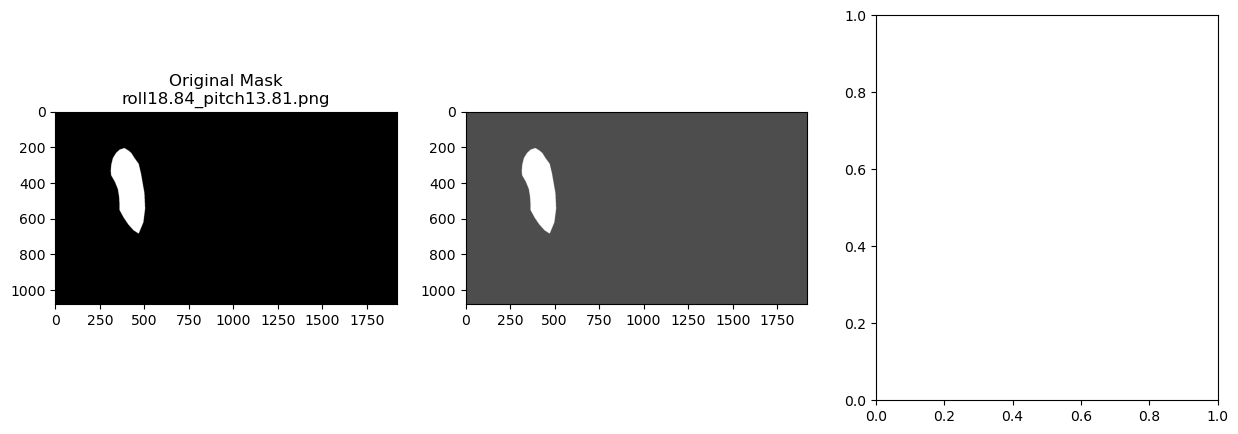

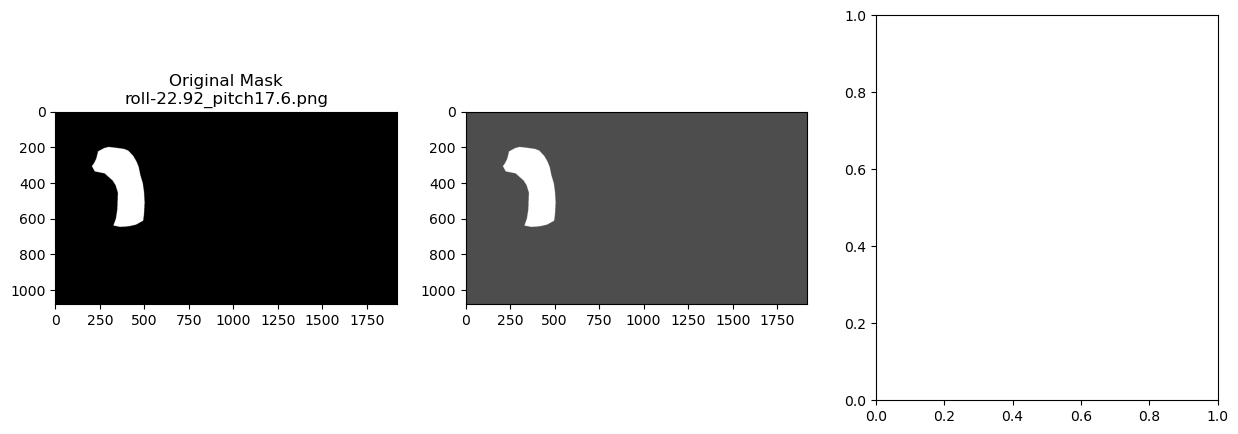

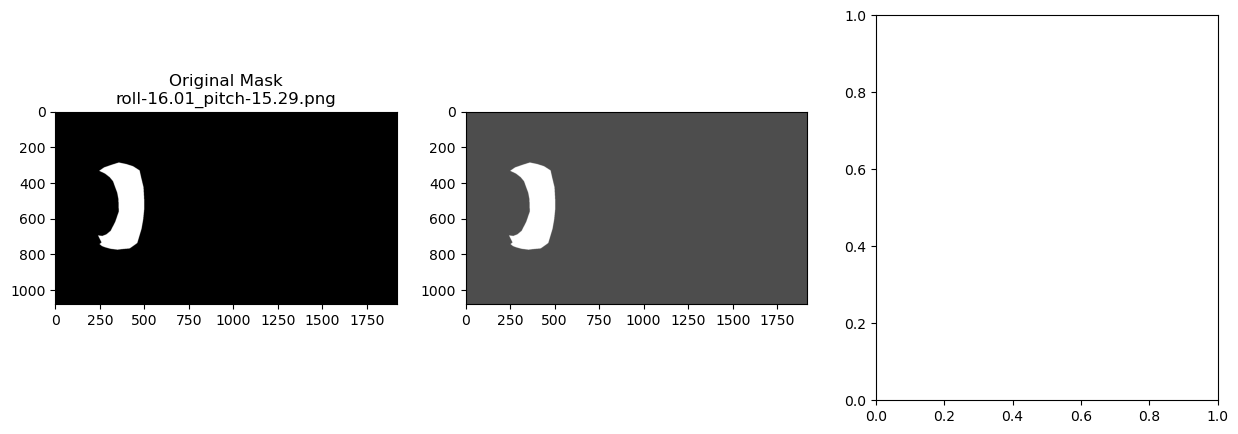

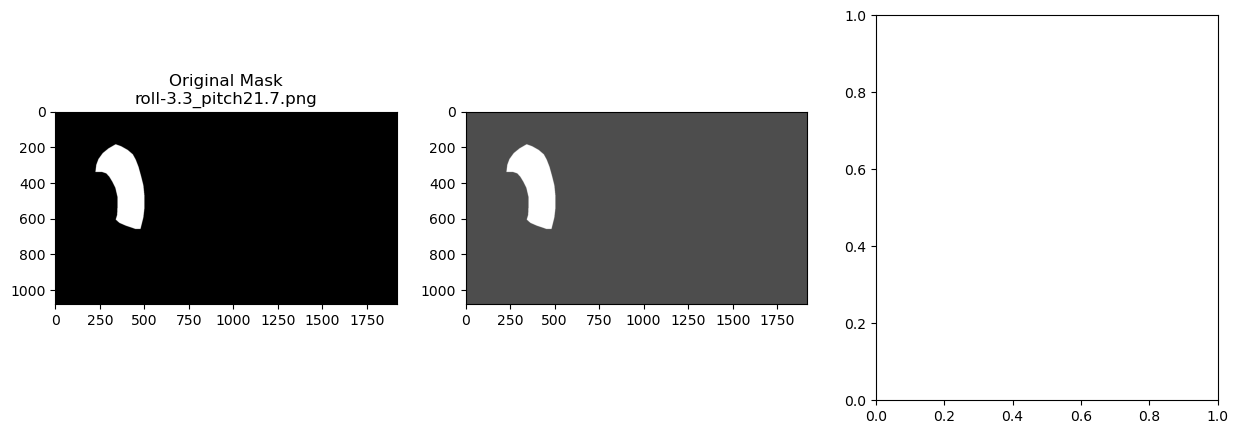

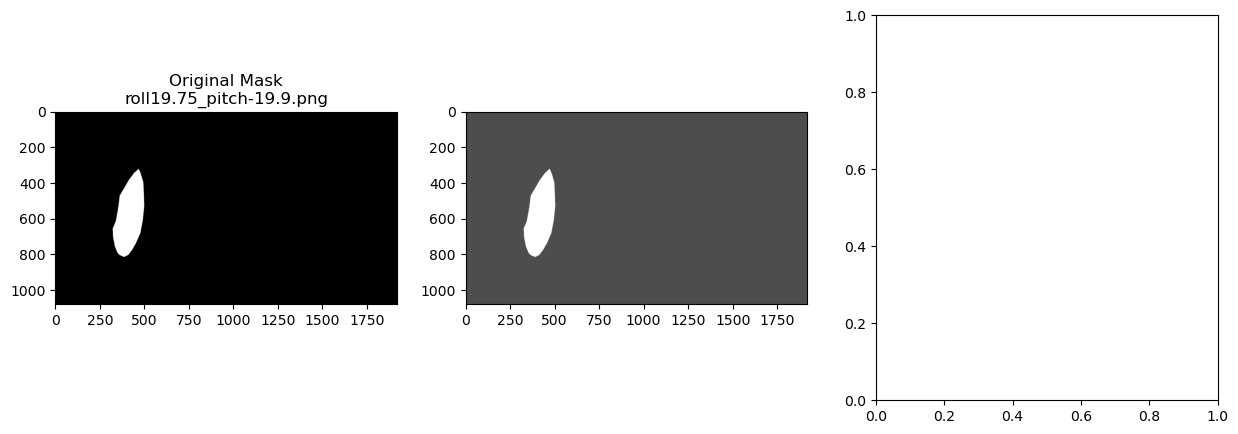

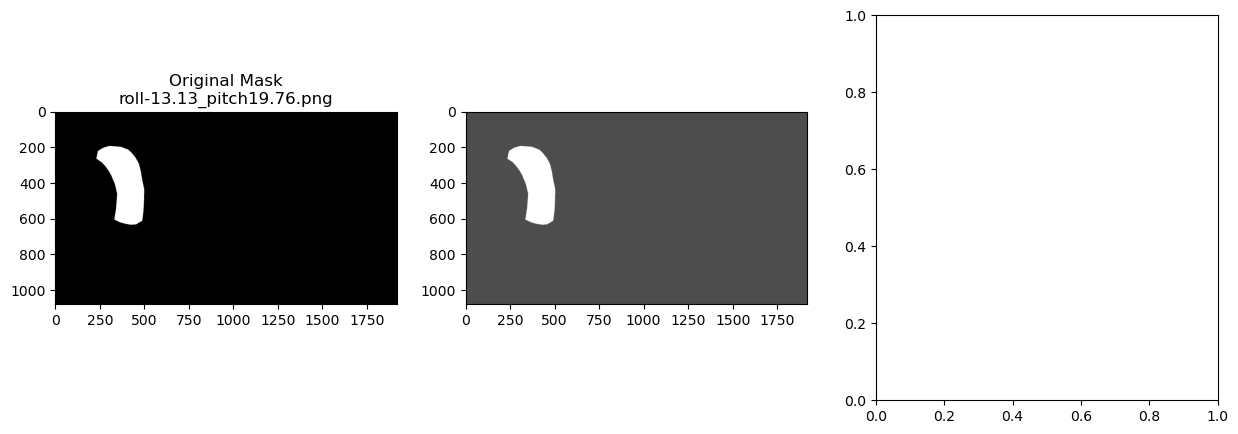

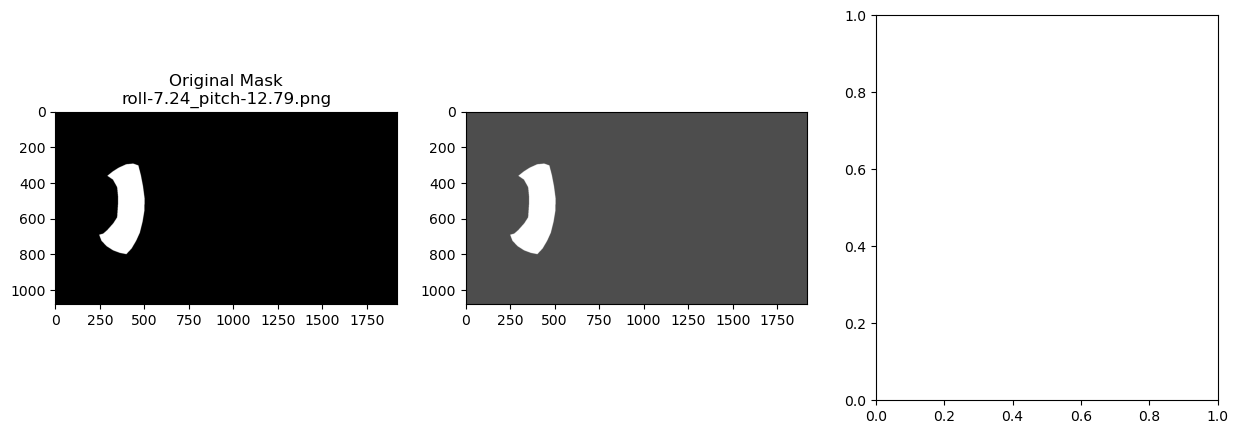

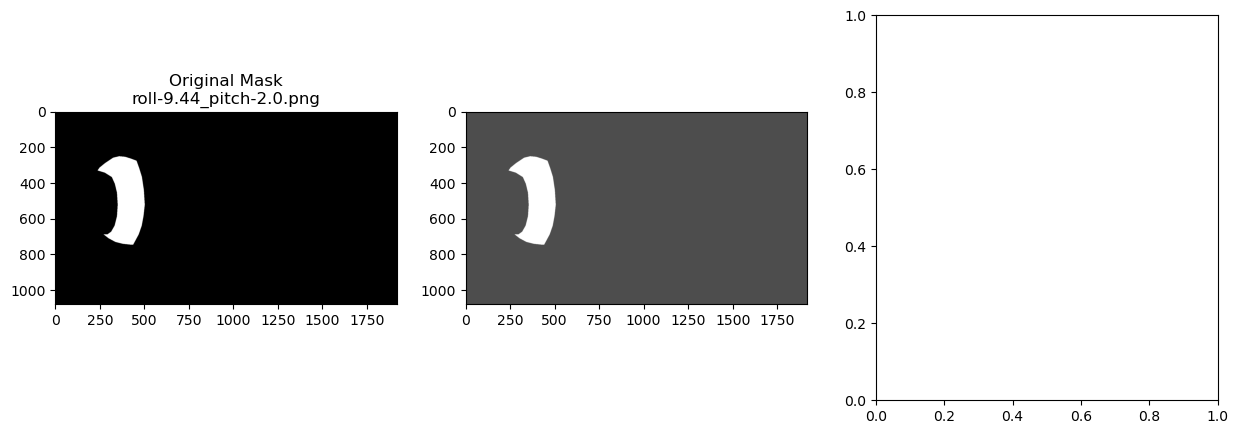

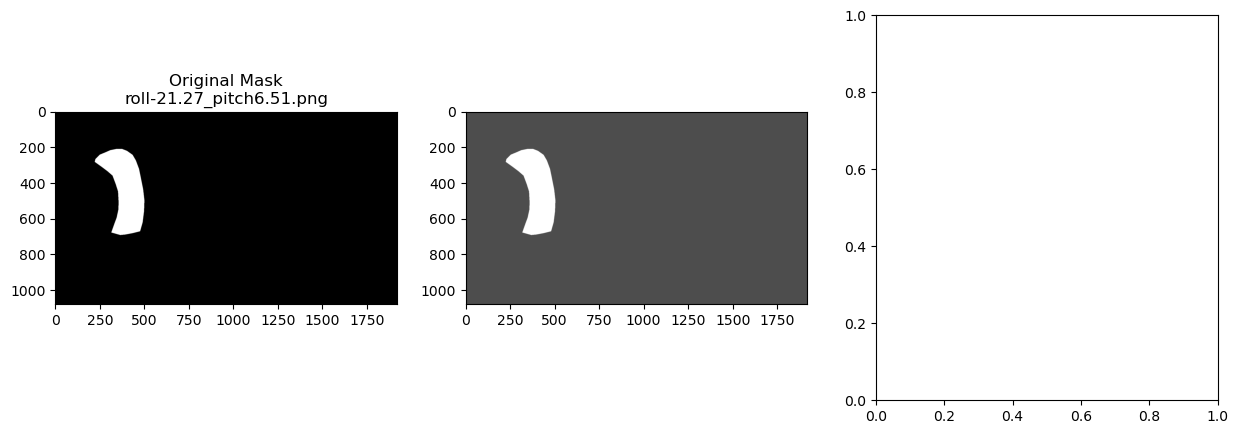

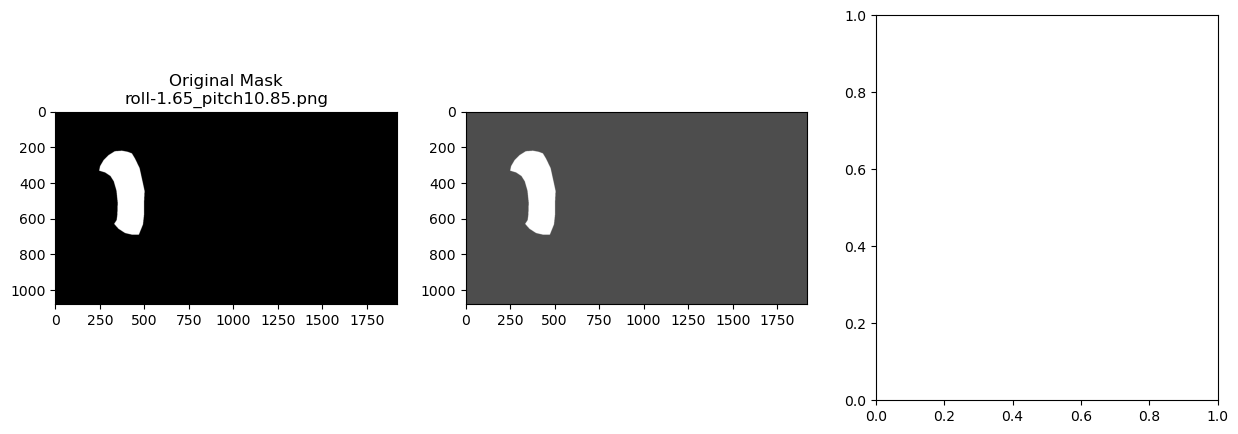

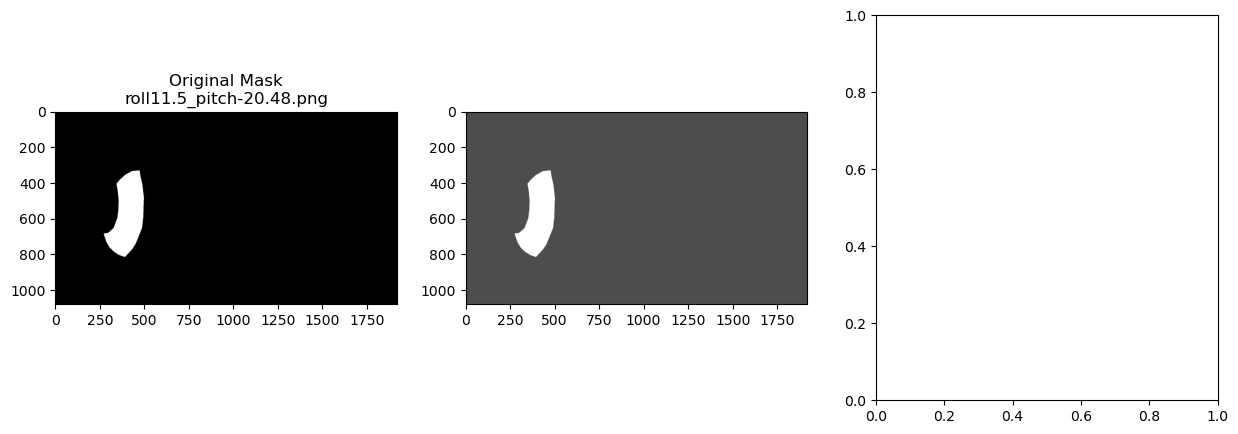

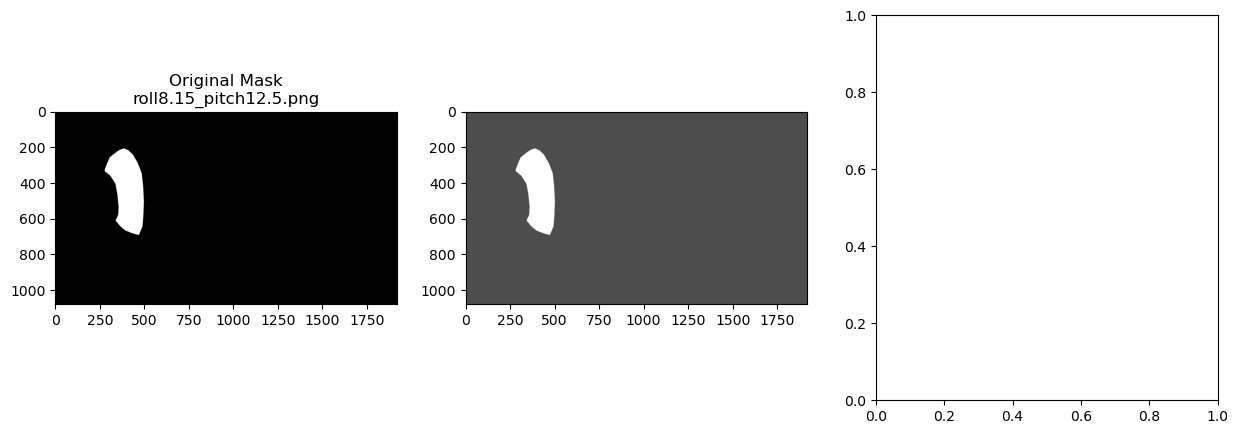

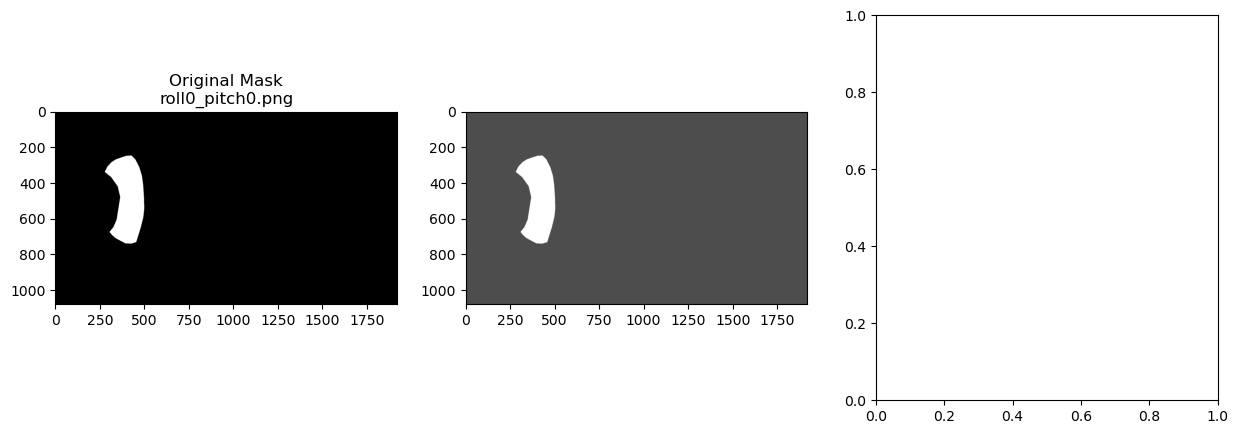

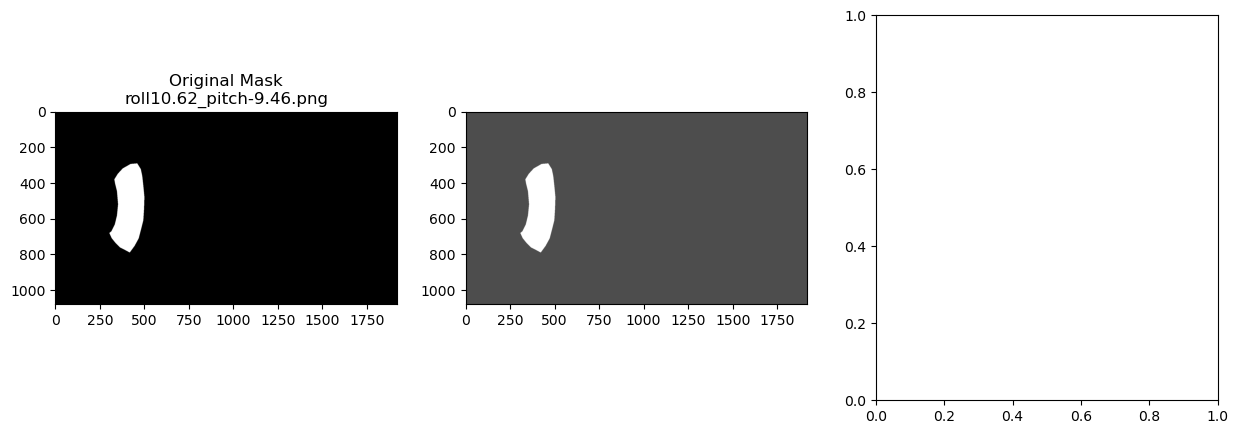

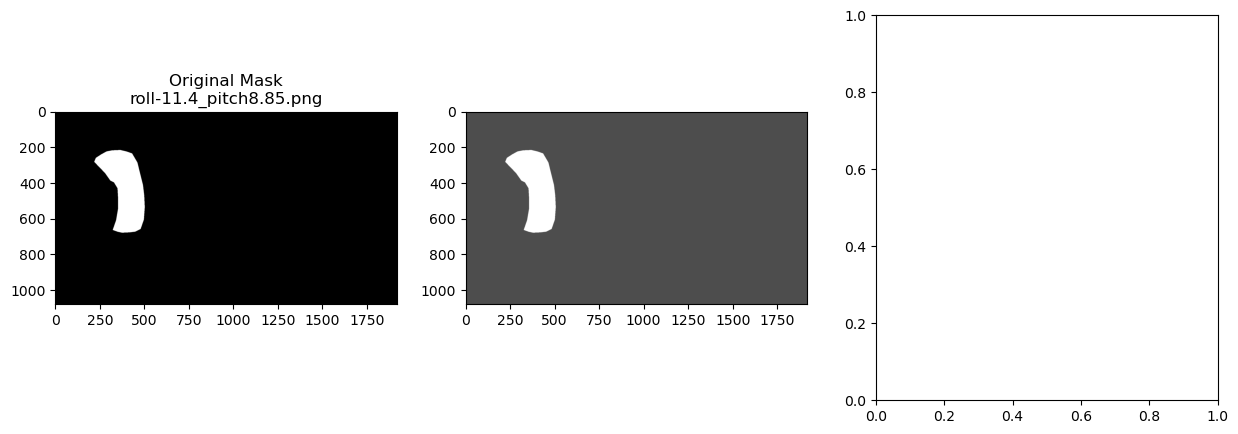

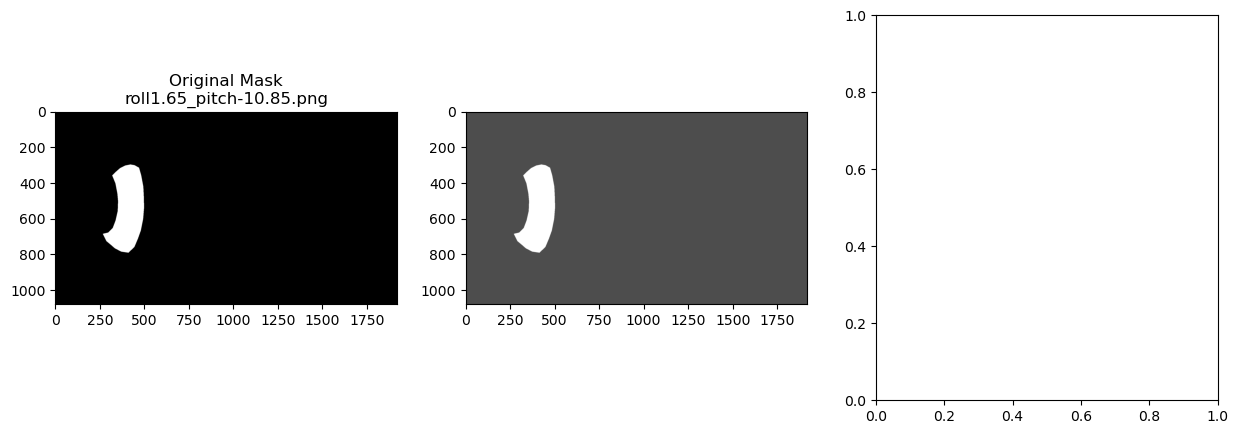

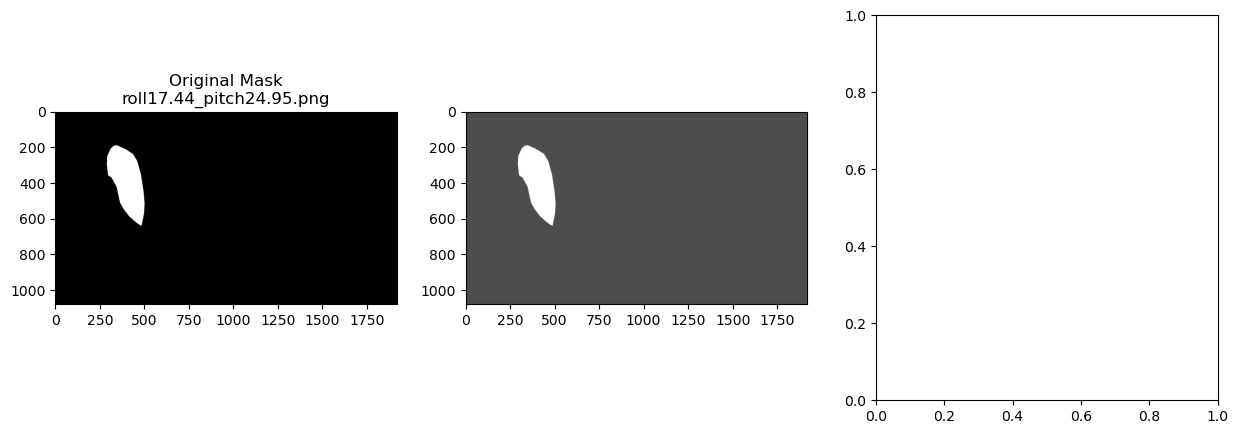

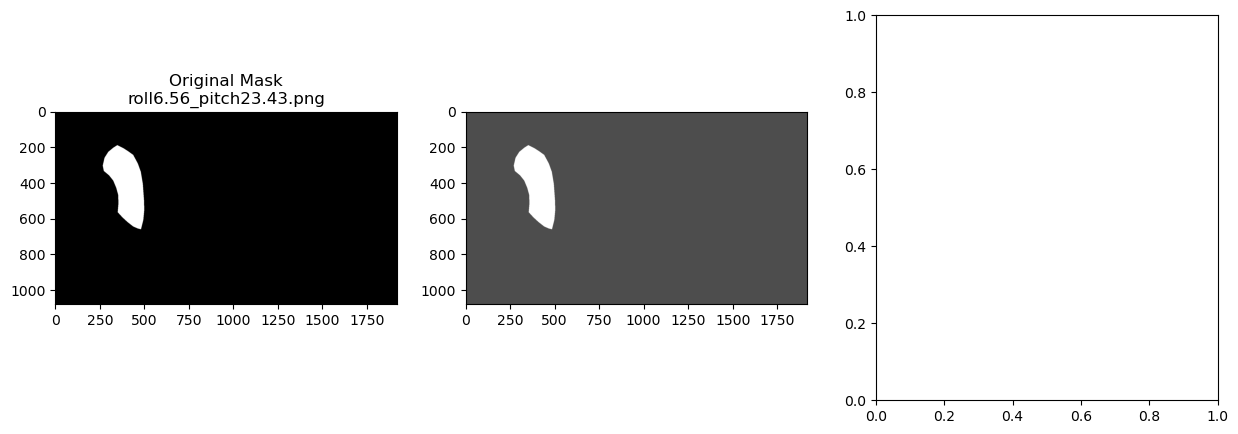

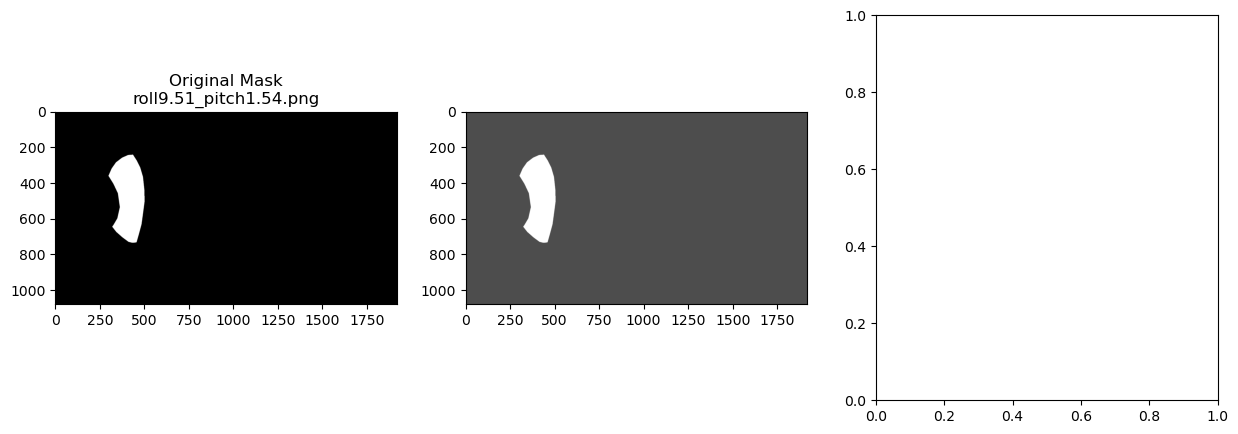

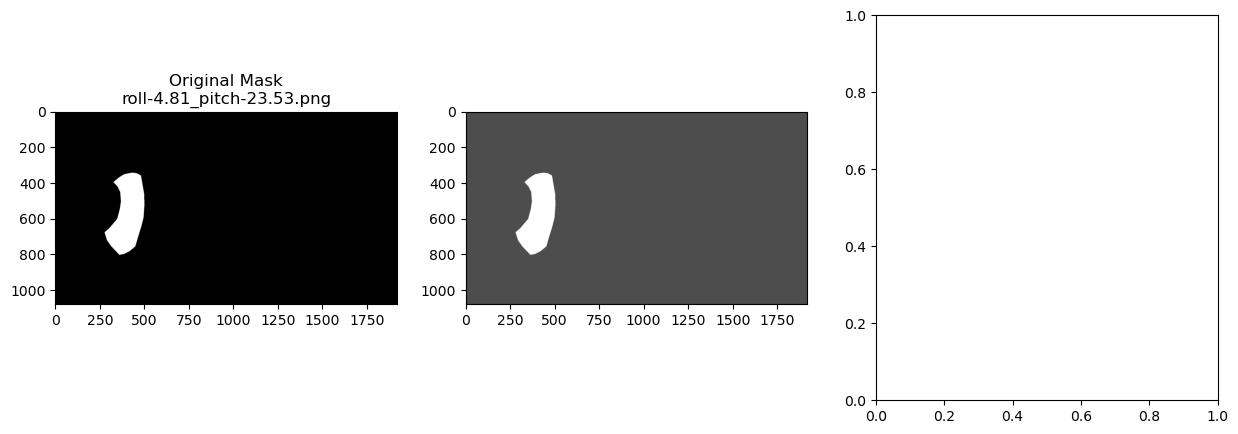

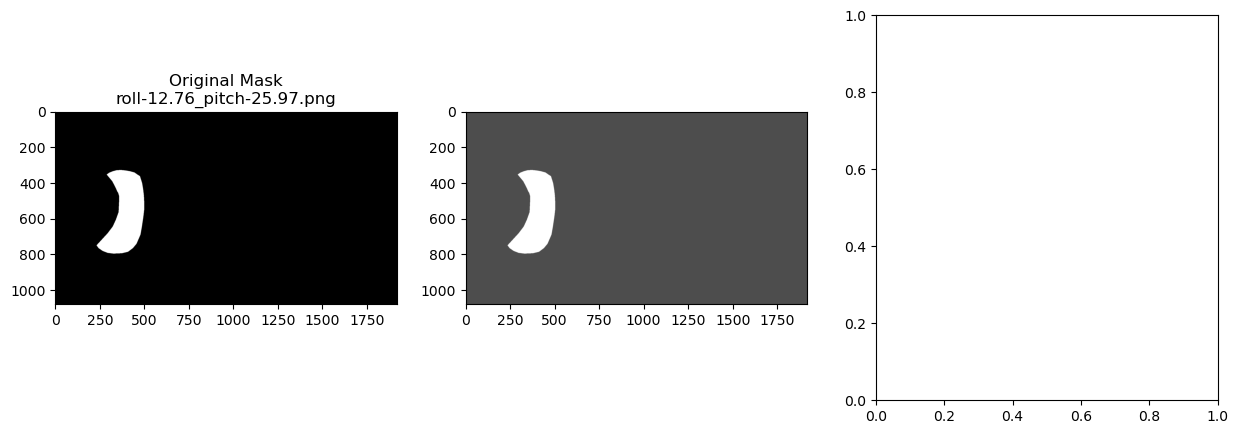

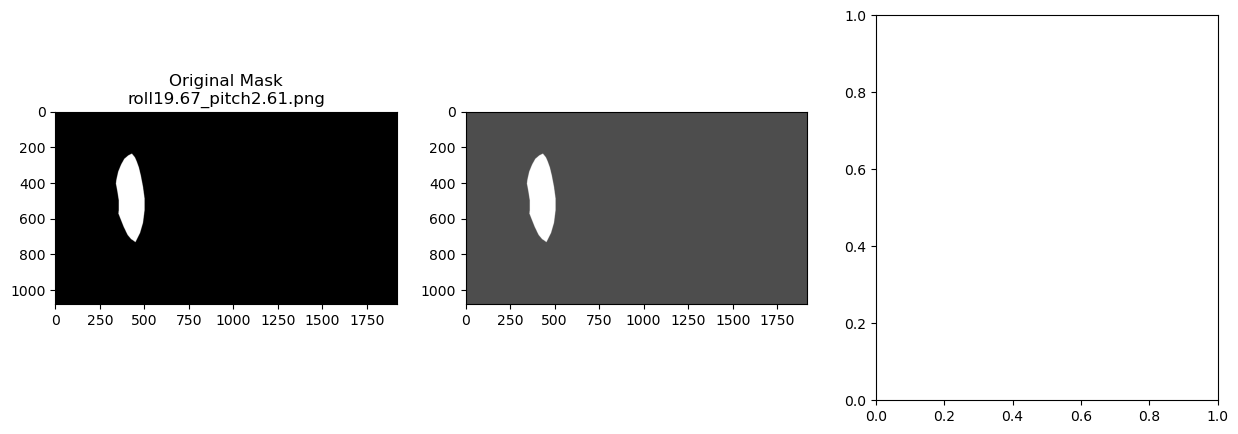

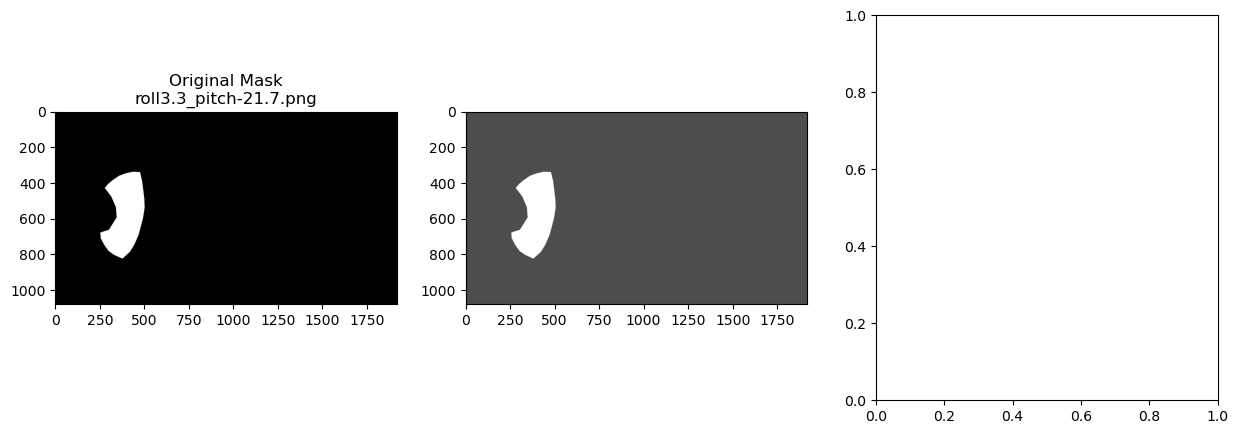

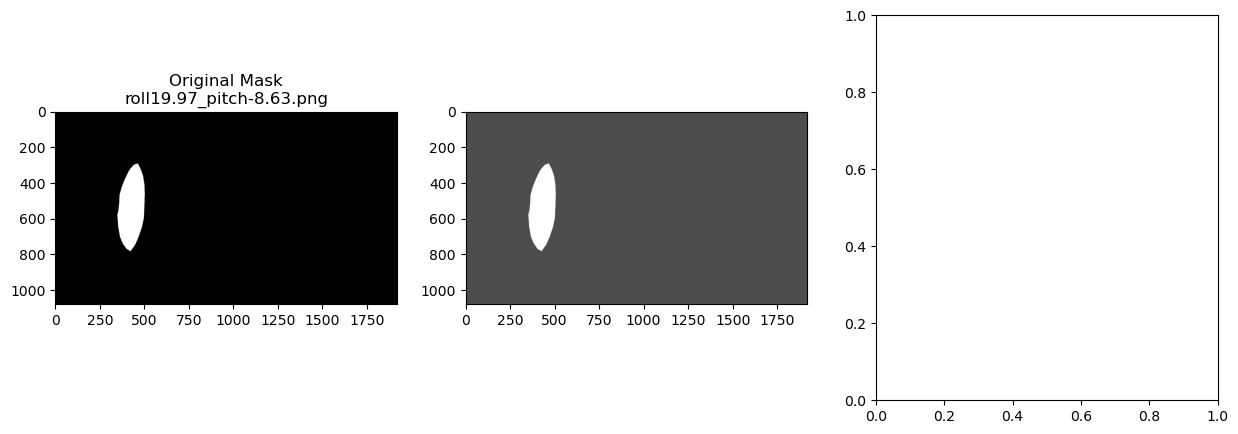

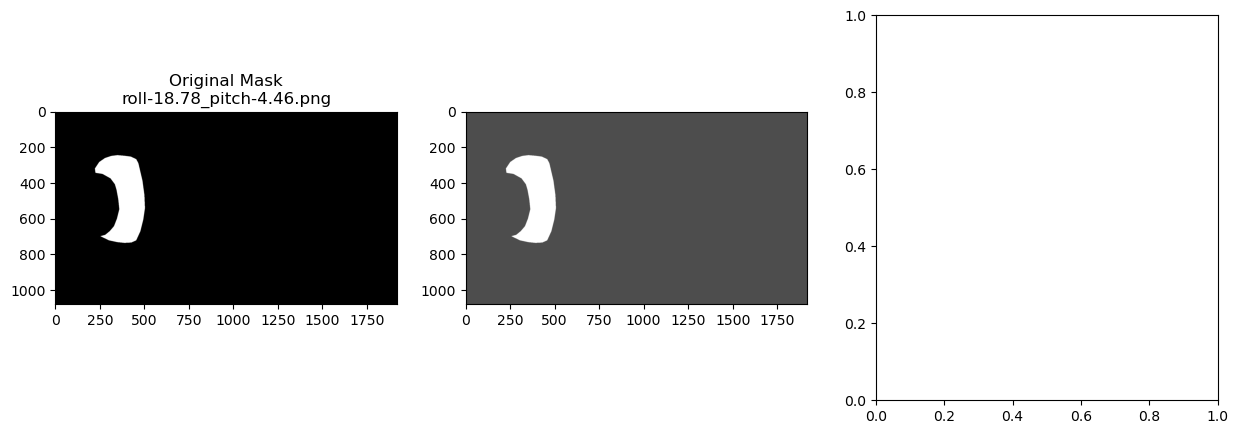

In [83]:
# Extract all contours with maximum detail
summary = batch_extract_contours(
    mask_folder=mask_folder,
    output_folder=output_contour_folder,
    keep_all_points=True  # ← This preserves ALL points!
)

In [ ]:
#@title get_mask_contour()
def get_mask_contour(mask_multi_inputs, image_data):

    processed_image = image_data["image_processed_denoise_light"]
    mask_2d = mask_multi_inputs[0]

    contours, _ = cv2.findContours(mask_2d.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if mask_2d is not None:
          contours, _ = cv2.findContours(mask_2d.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

          if contours:    # If there are no contours (all black image), avoid proceeding to prevent errors
              # Calculate areas
              areas = [cv2.contourArea(cnt) for cnt in contours]

              # Get the index of the largest contour
              largest_contour_index = np.argmax(areas)

              # Create a black image to draw the largest contour
              clean_mask = np.zeros_like(mask_2d, dtype=np.uint8)

              # Draw the largest contour
              cv2.drawContours(clean_mask, contours, largest_contour_index, color=1, thickness=-1)  # -1 thickness to fill the contour

              # Update the mask in the image_data dictionary
              # image_data[key]["mask_cleaned_multi_input"] = clean_mask

              # extract the outline of the 2D mask
              edges = cv2.Canny(clean_mask.astype(np.uint8)*255, 100, 200)
              y, x = np.where(edges == 255)
              largest_contour = np.column_stack((x, y))

              # -------------------- fill in image_data dictionary -------------------- #
              fill_image_dict(image_data, "mask_cleaned_multi_input", clean_mask)
              fill_image_dict(image_data, "outline_point", largest_contour)

              # -------------------- display -------------------- #
              # display_contour(processed_image, "segment by multi inputs", clean_mask, input_multi_points, input_multi_labels, 100, largest_contour)

    return largest_contour, image_data

In [ ]:
polisher_outline, image_data = get_mask_contour(mask_multiple, image_data)